In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import timm
from torch.utils.tensorboard import SummaryWriter


In [85]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = timm.create_model("tf_efficientnet_b5_ns",pretrained=True) 
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=7, bias=True))
        
        self.FILE = "model.pth"
        self.in_size = (3,224,224)
    def save_model(self):
        torch.save(model.state_dict(), FILE)   
    def load_model(self):
        self.model.load_state_dict(torch.load(FILE))
    def train_mode(self):
        self.model.train()
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.classifier.parameters():
            param.requires_grad = True
        for param in self.model.conv_head.parameters():
            param.requires_grad = True
        for param in self.model.bn2.parameters():
            param.requires_grad = True
    def eval_mode(self):
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False
    def forward(self,x):
        return self.model(x)
    def load_dict(self,dic):
        self.model.load_state_dict(dic,strict=False)
        

In [86]:
m = Model()
m.model = torch.load("0.85.pth").model

In [60]:
m.train_mode()

In [35]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

transforms= transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomResizedCrop(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

data_dir = 'data/train'
image_datasets =datasets.ImageFolder(os.path.join(data_dir),transform= transforms)
class_names = image_datasets.classes
train_size = int(0.85 * len(image_datasets))
test_size = len(image_datasets) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size, test_size], generator=torch.Generator().manual_seed(42))
image_datasets = {  'train':train_dataset,
                    'val':test_dataset
                 }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) 


['Andezit', 'Basalt', 'Diyorit', 'Granit', 'Riyolit', 'Siyenit', 'Trakit']


In [30]:
from pytorch_model_summary import summary
print(summary(m,torch.zeros((1, 3, 224, 224)), show_input=False,show_hierarchical = True))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [89]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,checkpoint = 2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            writer.add_scalar(str(phase)+'loss', epoch_loss)
            writer.add_scalar(str(phase)+'loss', epoch_acc)
            # deep copy the model
            if(phase == 'train'):
                torch.save(m.state_dict(),"model"+str(epoch)+"dict.pth")
                print("model is saved")
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            writer.close()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [90]:
writer = SummaryWriter('runs/model')
m = m.to(device)
m.train_mode()
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(m.parameters(), lr=0.001,momentum=0.2)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
m = train_model(m, criterion, optimizer, step_lr_scheduler, num_epochs=20,checkpoint=1)


Epoch 0/19
----------
train Loss: 0.5552 Acc: 0.8156
model is saved
val Loss: 0.5610 Acc: 0.8075
Epoch 1/19
----------
train Loss: 0.6209 Acc: 0.7827
model is saved
val Loss: 0.5718 Acc: 0.7826
Epoch 2/19
----------
train Loss: 0.6384 Acc: 0.7772
model is saved
val Loss: 0.5163 Acc: 0.8323
Epoch 3/19
----------
train Loss: 0.6298 Acc: 0.7827
model is saved
val Loss: 0.6572 Acc: 0.8012
Epoch 4/19
----------
train Loss: 0.6112 Acc: 0.7827
model is saved
val Loss: 0.5721 Acc: 0.8199
Epoch 5/19
----------
train Loss: 0.5951 Acc: 0.7816
model is saved
val Loss: 0.5424 Acc: 0.8137
Epoch 6/19
----------
train Loss: 0.5671 Acc: 0.8046
model is saved
val Loss: 0.4979 Acc: 0.7950
Epoch 7/19
----------
train Loss: 0.6291 Acc: 0.7783
model is saved
val Loss: 0.7351 Acc: 0.7516
Epoch 8/19
----------
train Loss: 0.5687 Acc: 0.7827
model is saved
val Loss: 0.5573 Acc: 0.8137
Epoch 9/19
----------
train Loss: 0.5829 Acc: 0.7936
model is saved
val Loss: 0.5713 Acc: 0.7888
Epoch 10/19
----------
train L

In [101]:
torch.save(m,"final_model.pth")


In [102]:
f = torch.load("final_model.pth")

In [95]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


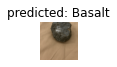

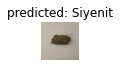

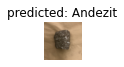

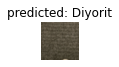

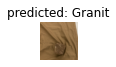

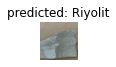

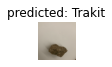

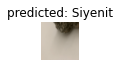

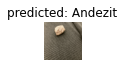

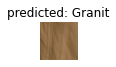

In [103]:
visualize_model(f)

In [118]:
nb_classes = 7
f.eval()
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = f(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[25.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1., 15.,  2.,  0.,  0.,  0.,  0.],
        [ 3.,  3., 21.,  4.,  0.,  1.,  0.],
        [ 1.,  2.,  2., 25.,  0.,  0.,  1.],
        [ 0.,  1.,  0.,  0., 16.,  0.,  1.],
        [ 1.,  0.,  4.,  2.,  0.,  9.,  0.],
        [ 1.,  0.,  1.,  0.,  0.,  2., 16.]])


In [119]:
print((confusion_matrix.diag())/confusion_matrix.sum(1))

tensor([0.9615, 0.8333, 0.6562, 0.8065, 0.8889, 0.5625, 0.8000])


In [120]:
confusion_matrix.diag().sum()/confusion_matrix.sum()

tensor(0.7888)